In [1]:

from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir(r'/content/gdrive/My Drive/License_Plate/Plate_detect_and_recognize')

Mounted at /content/gdrive


In [2]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

### Part 1: Extract license plate from sample image

In [3]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [4]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


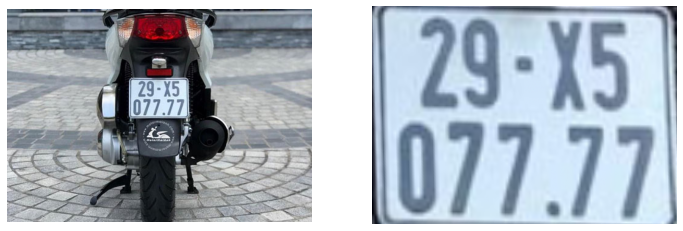

In [5]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

test_image_path = "Plate_examples/vietnam_motor_plate.jpg"

vehicle, LpImg, cor = get_plate(test_image_path)

# all_path = glob.glob("Plate_examples/*.jpg")
# vehicle, LpImg,cor = get_plate(test_image_path)

# vehicles = []
# LpImges = []
# cores = []

# for i, plate in enumerate(all_path):
#   v, L, c = get_plate(plate)
#   vehicles.append(v)
#   LpImges.append(L)
#   cores.append(c)

# for i in range(len(vehicles)):
#   fig = plt.figure(figsize=(12,6))
#   grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
#   fig.add_subplot(grid[0])
#   plt.axis(False)
#   plt.imshow(vehicles[i])
#   grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
#   fig.add_subplot(grid[1])
#   plt.axis(False)
#   plt.imshow(LpImges[i][0])
fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

## Part 2: Segementing license characters

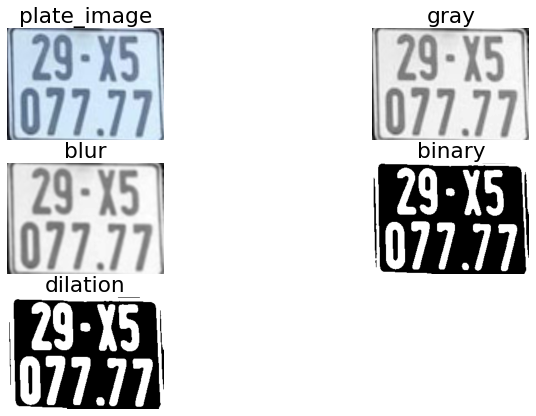

In [6]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

# plate_images = []

# img_greyes = []
# blurs = []
# binarys = []
# kernel3s = []
# thre_mors = []


# for i, LpImg in enumerate(LpImges):
#   if (len(LpImg)): #check if there is at least one license image
#     # Scales, calculates absolute values, and converts the result to 8-bit.
#     plate_images.append(cv2.convertScaleAbs(LpImg[0], alpha=(255.0)))
#     # convert to grayscale and blur the image
#     img_greyes.append(cv2.cvtColor(plate_images[i],cv2.COLOR_BGR2GRAY))
#     blurs.append(cv2.GaussianBlur(img_greyes[-1],(7,7),0))
    
#     # Applied inversed thresh_binary 
#     binarys.append(cv2.threshold(blurs[-1], 180, 255,
#                          cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1])
    
#     kernel3s.append(cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
#     thre_mors.append(cv2.morphologyEx(binarys[-1], cv2.MORPH_DILATE, kernel3s[-1]))



# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

24 107 35 85
45 10 34 84
70 106 33 86
83 11 34 83
116 108 32 84
162 14 33 82
180 110 32 84
200 14 35 82
225 111 34 84
Detect 9 letters...


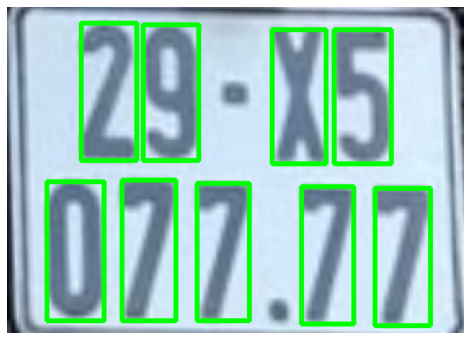

In [7]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts


# #set a thresh
# thresh = 100
# #get threshold image
# # rets = []
# # thresh_imges = []
# r, t = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
# # for grey in img_greyes:
# #   r, t = cv2.threshold(grey, thresh, 255, cv2.THRESH_BINARY)
# #   rets.append(r)
# #   thresh_imges.append(t)

# # conts = []

# # for binary in binarys:
# #   c, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# #   conts.append(c)

# cont, _ = cv2.findContours(t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # creat a copy version "test_roi" of plat_image to draw bounding box
# test_roi = plate_image.copy()

# # test_roies = []

# # for plate in plate_images:
# #   test_roies.append(plate.copy())


# # Initialize a list which will be used to append charater image
# crop_characters = []

# # for i in enumerate(conts):
# #   l = []
# #   crop_characters.append(l)
# # define standard width and height of character
# digit_w, digit_h = 30, 60

# # for i, cont in enumerate(conts):
# #   for c in sort_contours(cont):
# #     (x, y, w, h) = cv2.boundingRect(c)
# #     ratio = h/w
# #     if 1<=ratio<=5: # Only select contour with defined ratio
# #         if h/plate_images[i].shape[0]>=0.3: # Select contour which has the height larger than 50% of the plate
# #             # Draw bounding box arroung digit number
# #             cv2.rectangle(test_roies[i], (x, y), (x + w, y + h), (0, 255,0), 2)

# #             # Sperate number and gibe prediction
# #             curr_num = thre_mors[i][y:y+h,x:x+w]
# #             curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
# #             _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# #             crop_characters[i].append(curr_num)





# for c in sort_contours(cont):
#     (x, y, w, h) = cv2.boundingRect(c)
#     ratio = h/w
#     if 1<=ratio<=6: # Only select contour with defined ratio
#         if h/plate_image.shape[0]>=0.1: # Select contour which has the height larger than 50% of the plate
#             # Draw bounding box arroung digit number
#             cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

#             # Sperate number and gibe prediction
#             curr_num = thre_mor[y:y+h,x:x+w]
#             curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
#             _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#             crop_characters.append(curr_num)

# # for i, c in enumerate(crop_characters):
# #   print("Detect {} letters...".format(len(c)))
# #   fig = plt.figure(figsize=(10,6))
# #   plt.axis(False)
# #   plt.imshow(test_roies[i])
# print("Detect {} letters...".format(len(crop_characters)))
# fig = plt.figure(figsize=(10,6))
# plt.axis(False)
# plt.imshow(test_roi)
# plt.savefig('grab_digit_contour.png',dpi=300)

# Create sort_contours() function to grab the contour of each digit from left to right

# while len(keypoints) > 0:
#     a = sorted(keypoints, key=lambda p: (p[0]) + (p[1]))[0]  # find upper left point
#     b = sorted(keypoints, key=lambda p: (p[0]) - (p[1]))[-1]  # find upper right point

#     cv2.line(image_final, (int(a.pt[0]), int(a.pt[1])), (int(b.pt[0]), int(b.pt[1])), (255, 0, 0), 1)

#     # convert opencv keypoint to numpy 3d point
#     a = np.array([a.pt[0], a.pt[1], 0])
#     b = np.array([b.pt[0], b.pt[1], 0])

#     row_points = []
#     remaining_points = []
#     for k in keypoints:
#         p = np.array([k.pt[0], k.pt[1], 0])
#         d = k.size  # diameter of the keypoint (might be a theshold)
#         dist = np.linalg.norm(np.cross(np.subtract(p, a), np.subtract(b, a))) / np.linalg.norm(b)   # distance between keypoint and line a->b
#         if d/2 > dist:
#             row_points.append(k)
#         else:
#             remaining_points.append(k)

#     points.extend(sorted(row_points, key=lambda h: h.pt[0]))
#     keypoints= remaining_points

# def sort_contours(cnts,reverse = False):
#   keypoints = [cv2.boundingRect(c) for c in cnts]
#   while len(keypoints) > 0:
#     a = sorted(keypoints, key=lambda p: (p[0]) + (p[1]))[0]  # find upper left point
#     b = sorted(keypoints, key=lambda p: (p[0]) - (p[1]))[-1]  # find upper right point

#     cv2.line(plate_image, (int(a.pt[0]), int(a.pt[1])), (int(b.pt[0]), int(b.pt[1])), (255, 0, 0), 1)

#     # convert opencv keypoint to numpy 3d point
#     a = np.array([a.pt[0], a.pt[1], 0])
#     b = np.array([b.pt[0], b.pt[1], 0])

#     row_points = []
#     remaining_points = []
#     for k in keypoints:
#         p = np.array([k.pt[0], k.pt[1], 0])
#         d = k.size  # diameter of the keypoint (might be a theshold)
#         dist = np.linalg.norm(np.cross(np.subtract(p, a), np.subtract(b, a))) / np.linalg.norm(b)   # distance between keypoint and line a->b
#         if d/2 > dist:
#             row_points.append(k)
#         else:
#             remaining_points.append(k)

#     points.extend(sorted(row_points, key=lambda h: h.pt[0]))
#     keypoints= remaining_points
#     (cnts, keypoints) = zip(*sorted(zip(cnts, keypoints),
#                                          key=lambda b: b[1], reverse=reverse))
#     return cnts

# def sort_contours(cnts,reverse = False):
#     i = 1
#     boundingBoxes = [cv2.boundingRect(c) for c in cnts]
#     boundingBoxes_2 = []
#     for i in range(len(boundingBoxes)):
#       boundingBoxes_2.append(boundingBoxes[i][0]+boundingBoxes[i][1])
#     (cnts, boundingBoxes_2) = zip(*sorted(zip(cnts, boundingBoxes_2),
#                                         key=lambda b: b[1], reverse=reverse))
#     return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60
for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=6: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.1: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
            print(x, y, w, h)
            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
plt.savefig('grab_digit_contour.png',dpi=300)

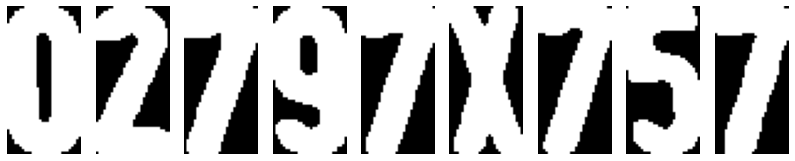

In [8]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)



for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
plt.savefig("segmented_leter1.png",dpi=300)    

## Load pre-trained MobileNets model and predict

In [9]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [10]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

02797X757


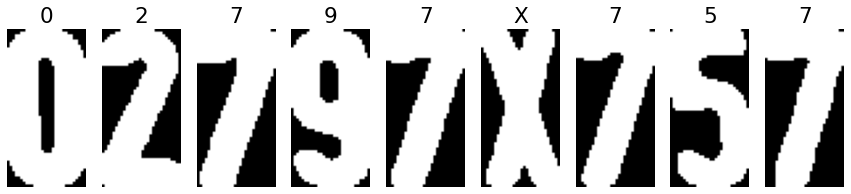

In [11]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
plt.savefig('final_result1.png', dpi=300)

# The end!